In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os.path as op
import time

from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.optimizers import Adam
from keras_tqdm import TQDMNotebookCallback
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook

from fastmri_recon.data.fastmri_sequences import ZeroFilled2DSequence
from fastmri_recon.helpers.adversarial_training import compile_models, adversarial_training_loop
from fastmri_recon.helpers.keras_utils import wasserstein_loss
from fastmri_recon.models.discriminator import discriminator_model, generator_containing_discriminator_multiple_outputs
from fastmri_recon.models.unet import unet

/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
run_params = {
    'n_layers': 4, 
    'pool': 'max', 
    "layers_n_channels": [16, 32, 64, 128], 
    'layers_n_non_lins': 2,
}

def generator_model():
    model = unet(input_size=(320, 320, 1), **run_params, compile=False)
    model.name = 'Reconstructor'
    return model

In [3]:
# model definitions
g = generator_model()
d = discriminator_model()
d_on_g = generator_containing_discriminator_multiple_outputs(g, d)

W1024 15:10:14.697746 139824715740928 deprecation_wrapper.py:119] From /volatile/home/Zaccharie/workspace/keras/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [4]:
# model compiling
perceptual_loss = 'mse'

lr = 1e-3

compile_models(d, g, d_on_g, lr=lr, perceptual_loss=perceptual_loss, perceptual_weight=1)

In [5]:
train_path = '/media/Zaccharie/UHRes/singlecoil_train/singlecoil_train/'
val_path = '/media/Zaccharie/UHRes/singlecoil_val/'
n_volumes_train = 973
n_volumes_val = 199
AF = 4
train_gen = ZeroFilled2DSequence(train_path, af=AF, norm=True)
val_gen = ZeroFilled2DSequence(val_path, af=AF, norm=True)

epoch_num = 4
critic_updates = 5

run_id = f'unet_gan_af{AF}_{int(time.time())}'
chkpt_path = f'checkpoints/{run_id}' + '-{epoch:02d}.hdf5'
print(run_id)

unet_gan_af4_1571922615


In [6]:
log_dir = op.join('logs', run_id)
tqdm_cb = TQDMNotebookCallback(metric_format="{name}: {value:e}")
tboard_cback = TensorBoard(
    log_dir=log_dir, 
    histogram_freq=0, 
    write_graph=True, 
    write_images=False, 
)
chkpt_cback = ModelCheckpoint(chkpt_path, period=500)

In [7]:
%%time
d_losses = adversarial_training_loop(
    g, 
    d, 
    d_on_g, 
    train_gen, 
    val_gen=val_gen,
    validation_steps=1,
    n_epochs=epoch_num, 
    n_batches=4, 
    n_critic_updates=critic_updates,
    callbacks=[tqdm_cb, tboard_cback, chkpt_cback],
)

W1024 15:10:17.952006 139824715740928 deprecation_wrapper.py:119] From /volatile/home/Zaccharie/workspace/keras/keras/callbacks/tensorboard_v1.py:200: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W1024 15:10:17.953678 139824715740928 deprecation_wrapper.py:119] From /volatile/home/Zaccharie/workspace/keras/keras/callbacks/tensorboard_v1.py:203: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



W1024 15:10:19.824025 139824715740928 deprecation_wrapper.py:119] From /volatile/home/Zaccharie/workspace/keras/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W1024 15:10:52.126470 139824715740928 deprecation_wrapper.py:119] From /volatile/home/Zaccharie/workspace/keras/keras/callbacks/tensorboard_v1.py:343: The name tf.Summary is deprecated. Please use tf.compat.v1.Summary instead.




CPU times: user 50.5 s, sys: 10.1 s, total: 1min
Wall time: 1min 15s


<IPython.core.display.Javascript object>


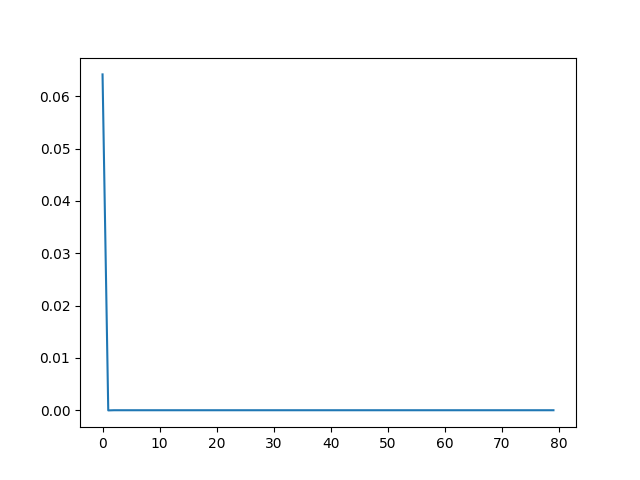

[0.06419527530670166, -3.123283386230469e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [8]:
plt.figure()
plt.plot(d_losses)
print(d_losses)